In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Gradient Descent to Find Optimal Parameter Values

In [2]:
X_poly = np.linspace(-3,5,81)
print(X_poly[:5], '...', X_poly[-5:])

[-3.  -2.9 -2.8 -2.7 -2.6] ... [4.6 4.7 4.8 4.9 5. ]


Text(0.5, 1.0, 'Error surface')

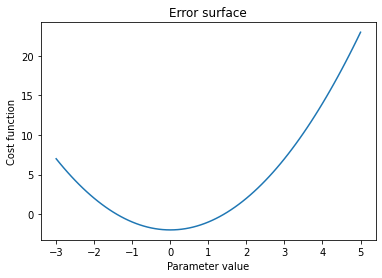

In [3]:
def cost_function(X):
    return X*X-2
y_poly = cost_function(X_poly)
plt.plot(X_poly,y_poly)
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.title('Error surface')

### Using Gradient Descent to Minimize a Cost Function

In [4]:
def gradient(X):
    return (2*X)-2
x_start = 4.5
learning_rate = 0.75
x_next = x_start - gradient(x_start)*learning_rate
x_next

-0.75

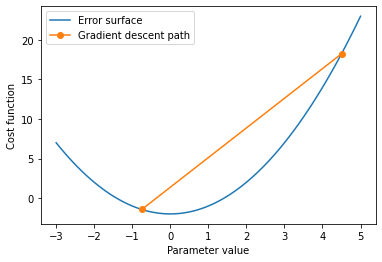

In [5]:
plt.plot(X_poly, y_poly)
plt.plot([x_start, x_next], [cost_function(x_start), cost_function(x_next)], '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

In [6]:
# Let's use number of iteration to reduce the cost function
iterations = 15
x_path = np.empty(iterations,)
x_path[0] = x_start
for iteration_count in range(1,iterations):
    derivative = gradient(x_path[iteration_count-1])
    x_path[iteration_count] = x_path[iteration_count-1] - (derivative*learning_rate)
x_path

array([ 4.5       , -0.75      ,  1.875     ,  0.5625    ,  1.21875   ,
        0.890625  ,  1.0546875 ,  0.97265625,  1.01367188,  0.99316406,
        1.00341797,  0.99829102,  1.00085449,  0.99957275,  1.00021362])

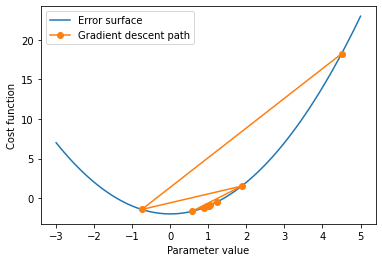

In [7]:
# let's visualize this
plt.plot(X_poly, y_poly)
plt.plot(x_path, cost_function(x_path), '-o')
plt.xlabel('Parameter value')
plt.ylabel('Cost function')
plt.legend(['Error surface', 'Gradient descent path'])

### Assumptions of Logistic Regression


In [8]:
# Check multico-linearity
df = pd.read_csv("E:/Technolabs/cleaned_final.csv")

In [9]:
features_response = df.columns.tolist()
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [10]:
features_response = [item for item in features_response if item not in items_to_remove]

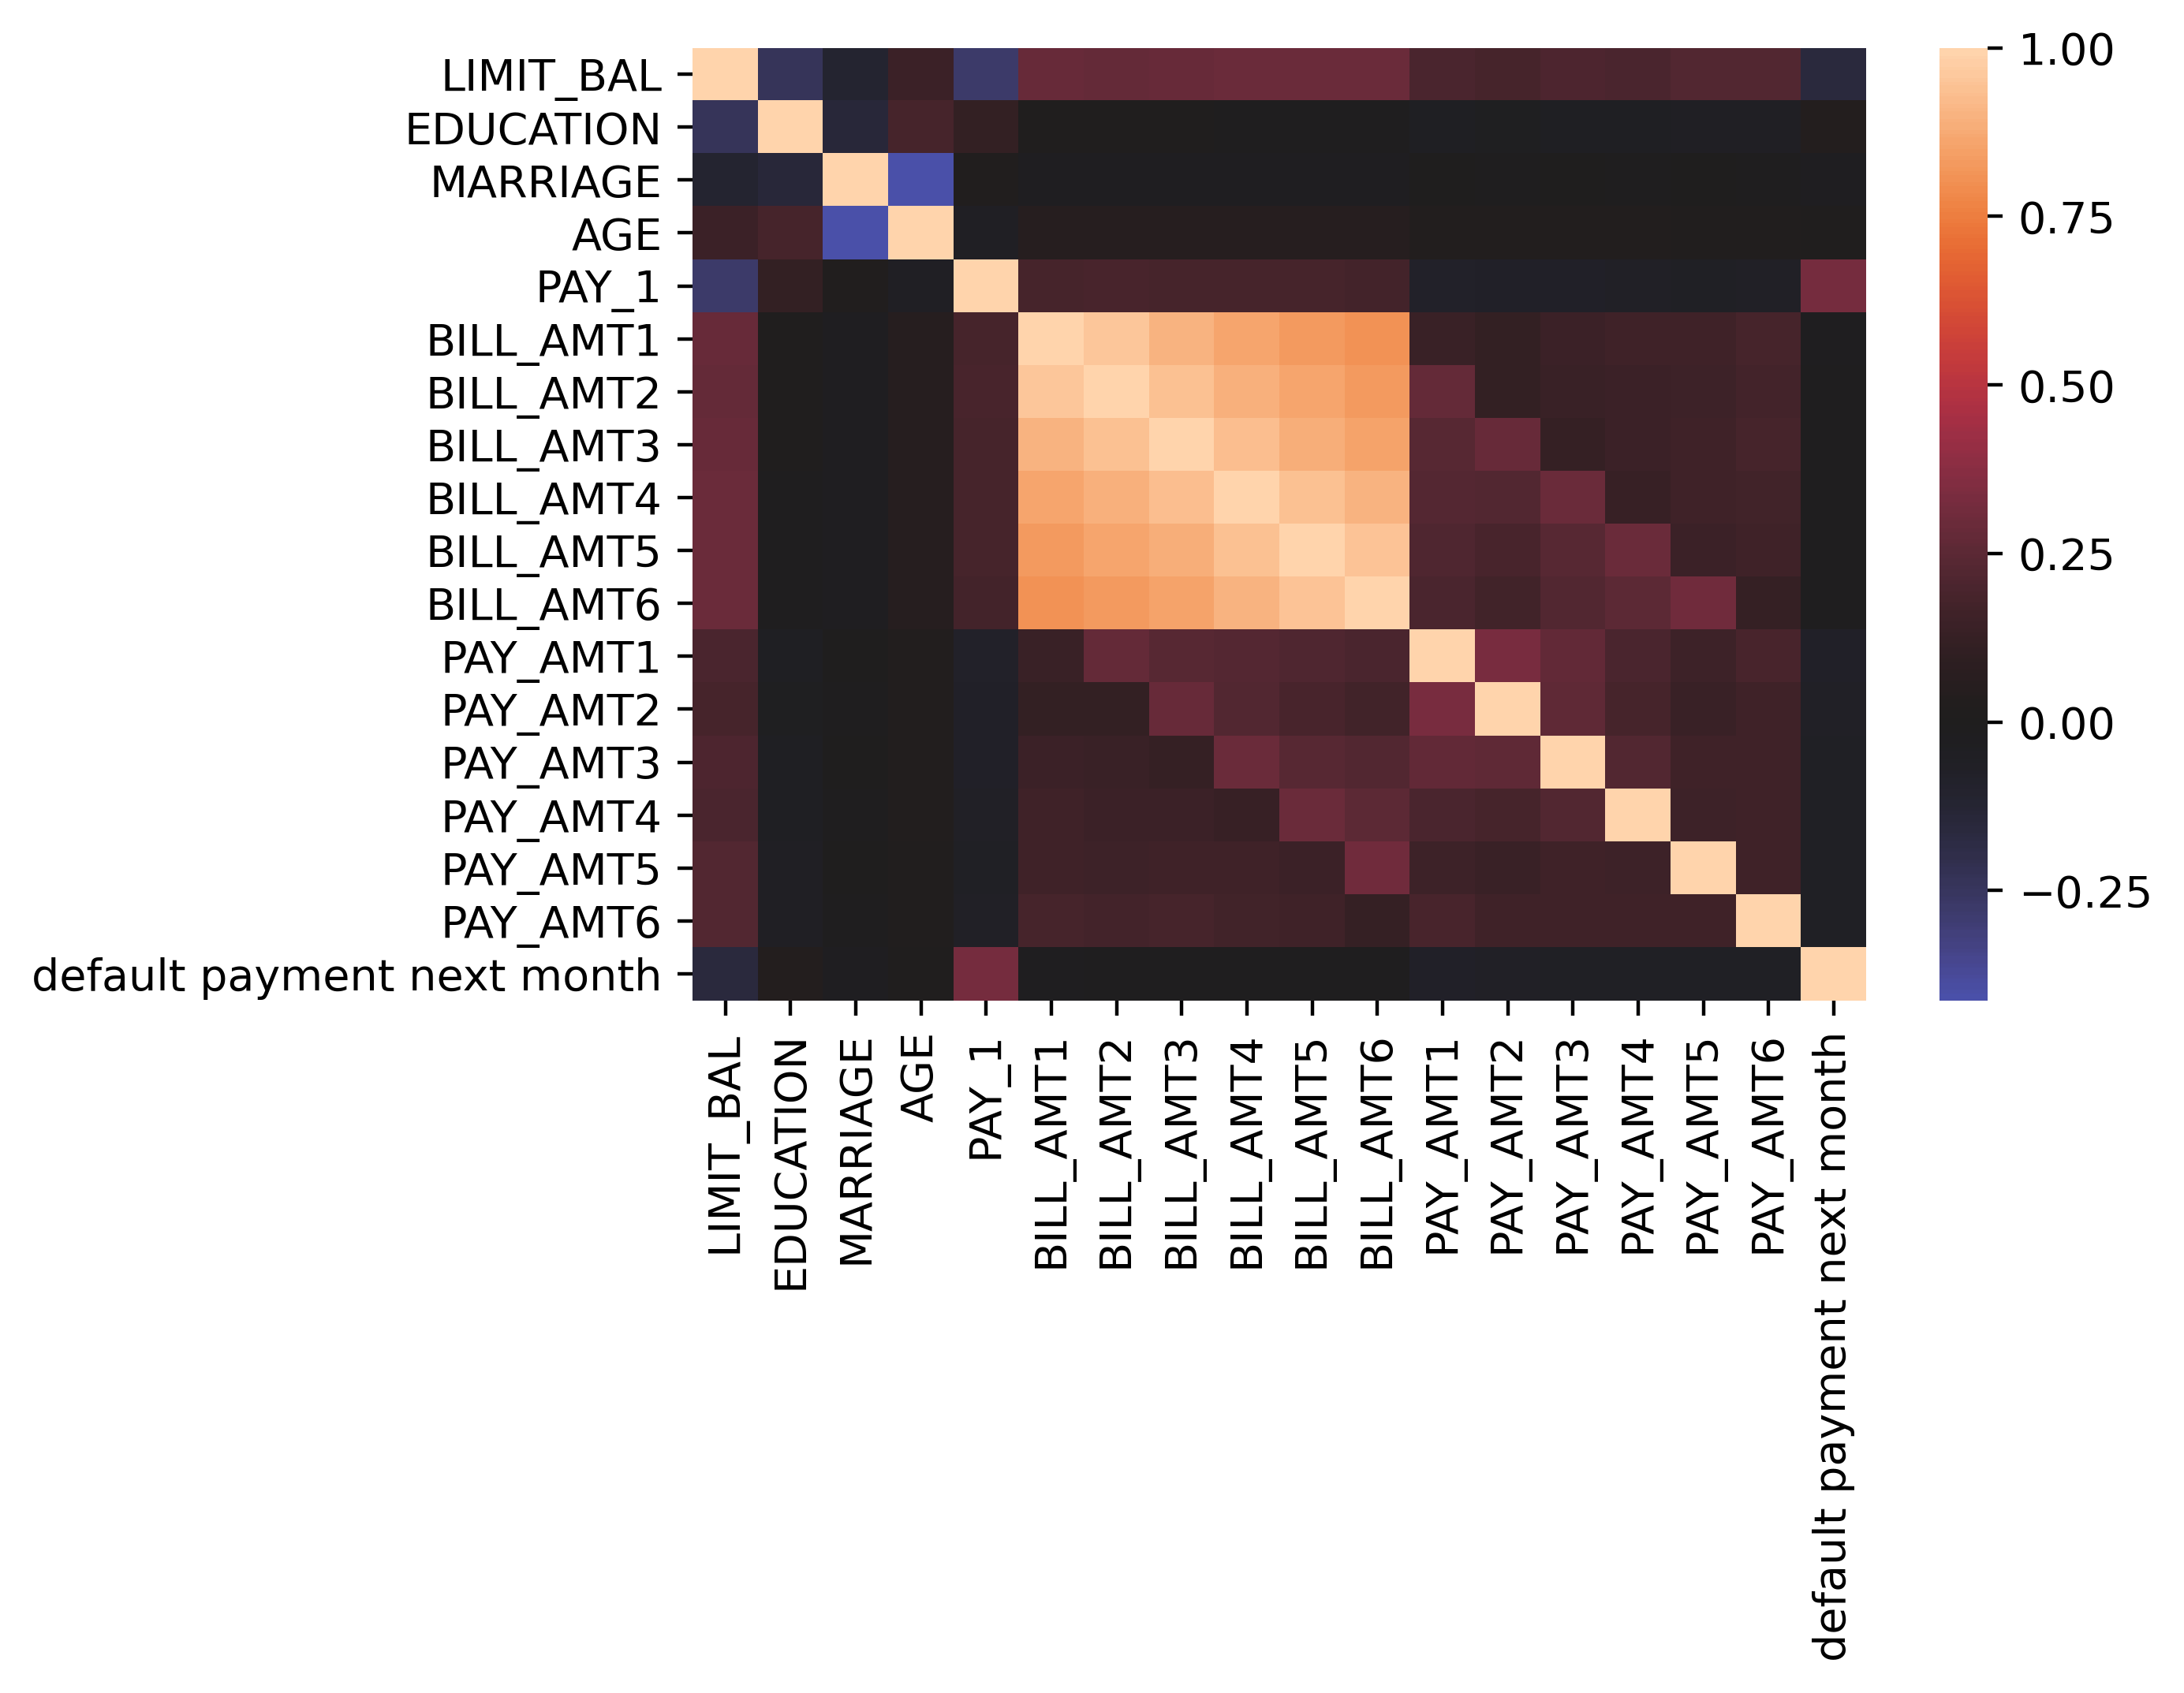

In [11]:
corr = df[features_response].corr()
mpl.rcParams['figure.dpi'] = 400 #high res figures
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            center=0)

### Generating and Modeling Synthetic Classification Data


In [12]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [13]:
# Let's create a dataset
X_synthetic, y_synthetic = make_classification(
    n_samples=1000, n_features=200,
    n_informative=3, n_redundant=10,
    n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=None,
    flip_y=0.01, class_sep=0.8,
    hypercube=True, shift=0.0,
    scale=1.0, shuffle=True,
    random_state=24
)

In [14]:
print(X_synthetic.shape,y_synthetic.shape)

(1000, 200) (1000,)


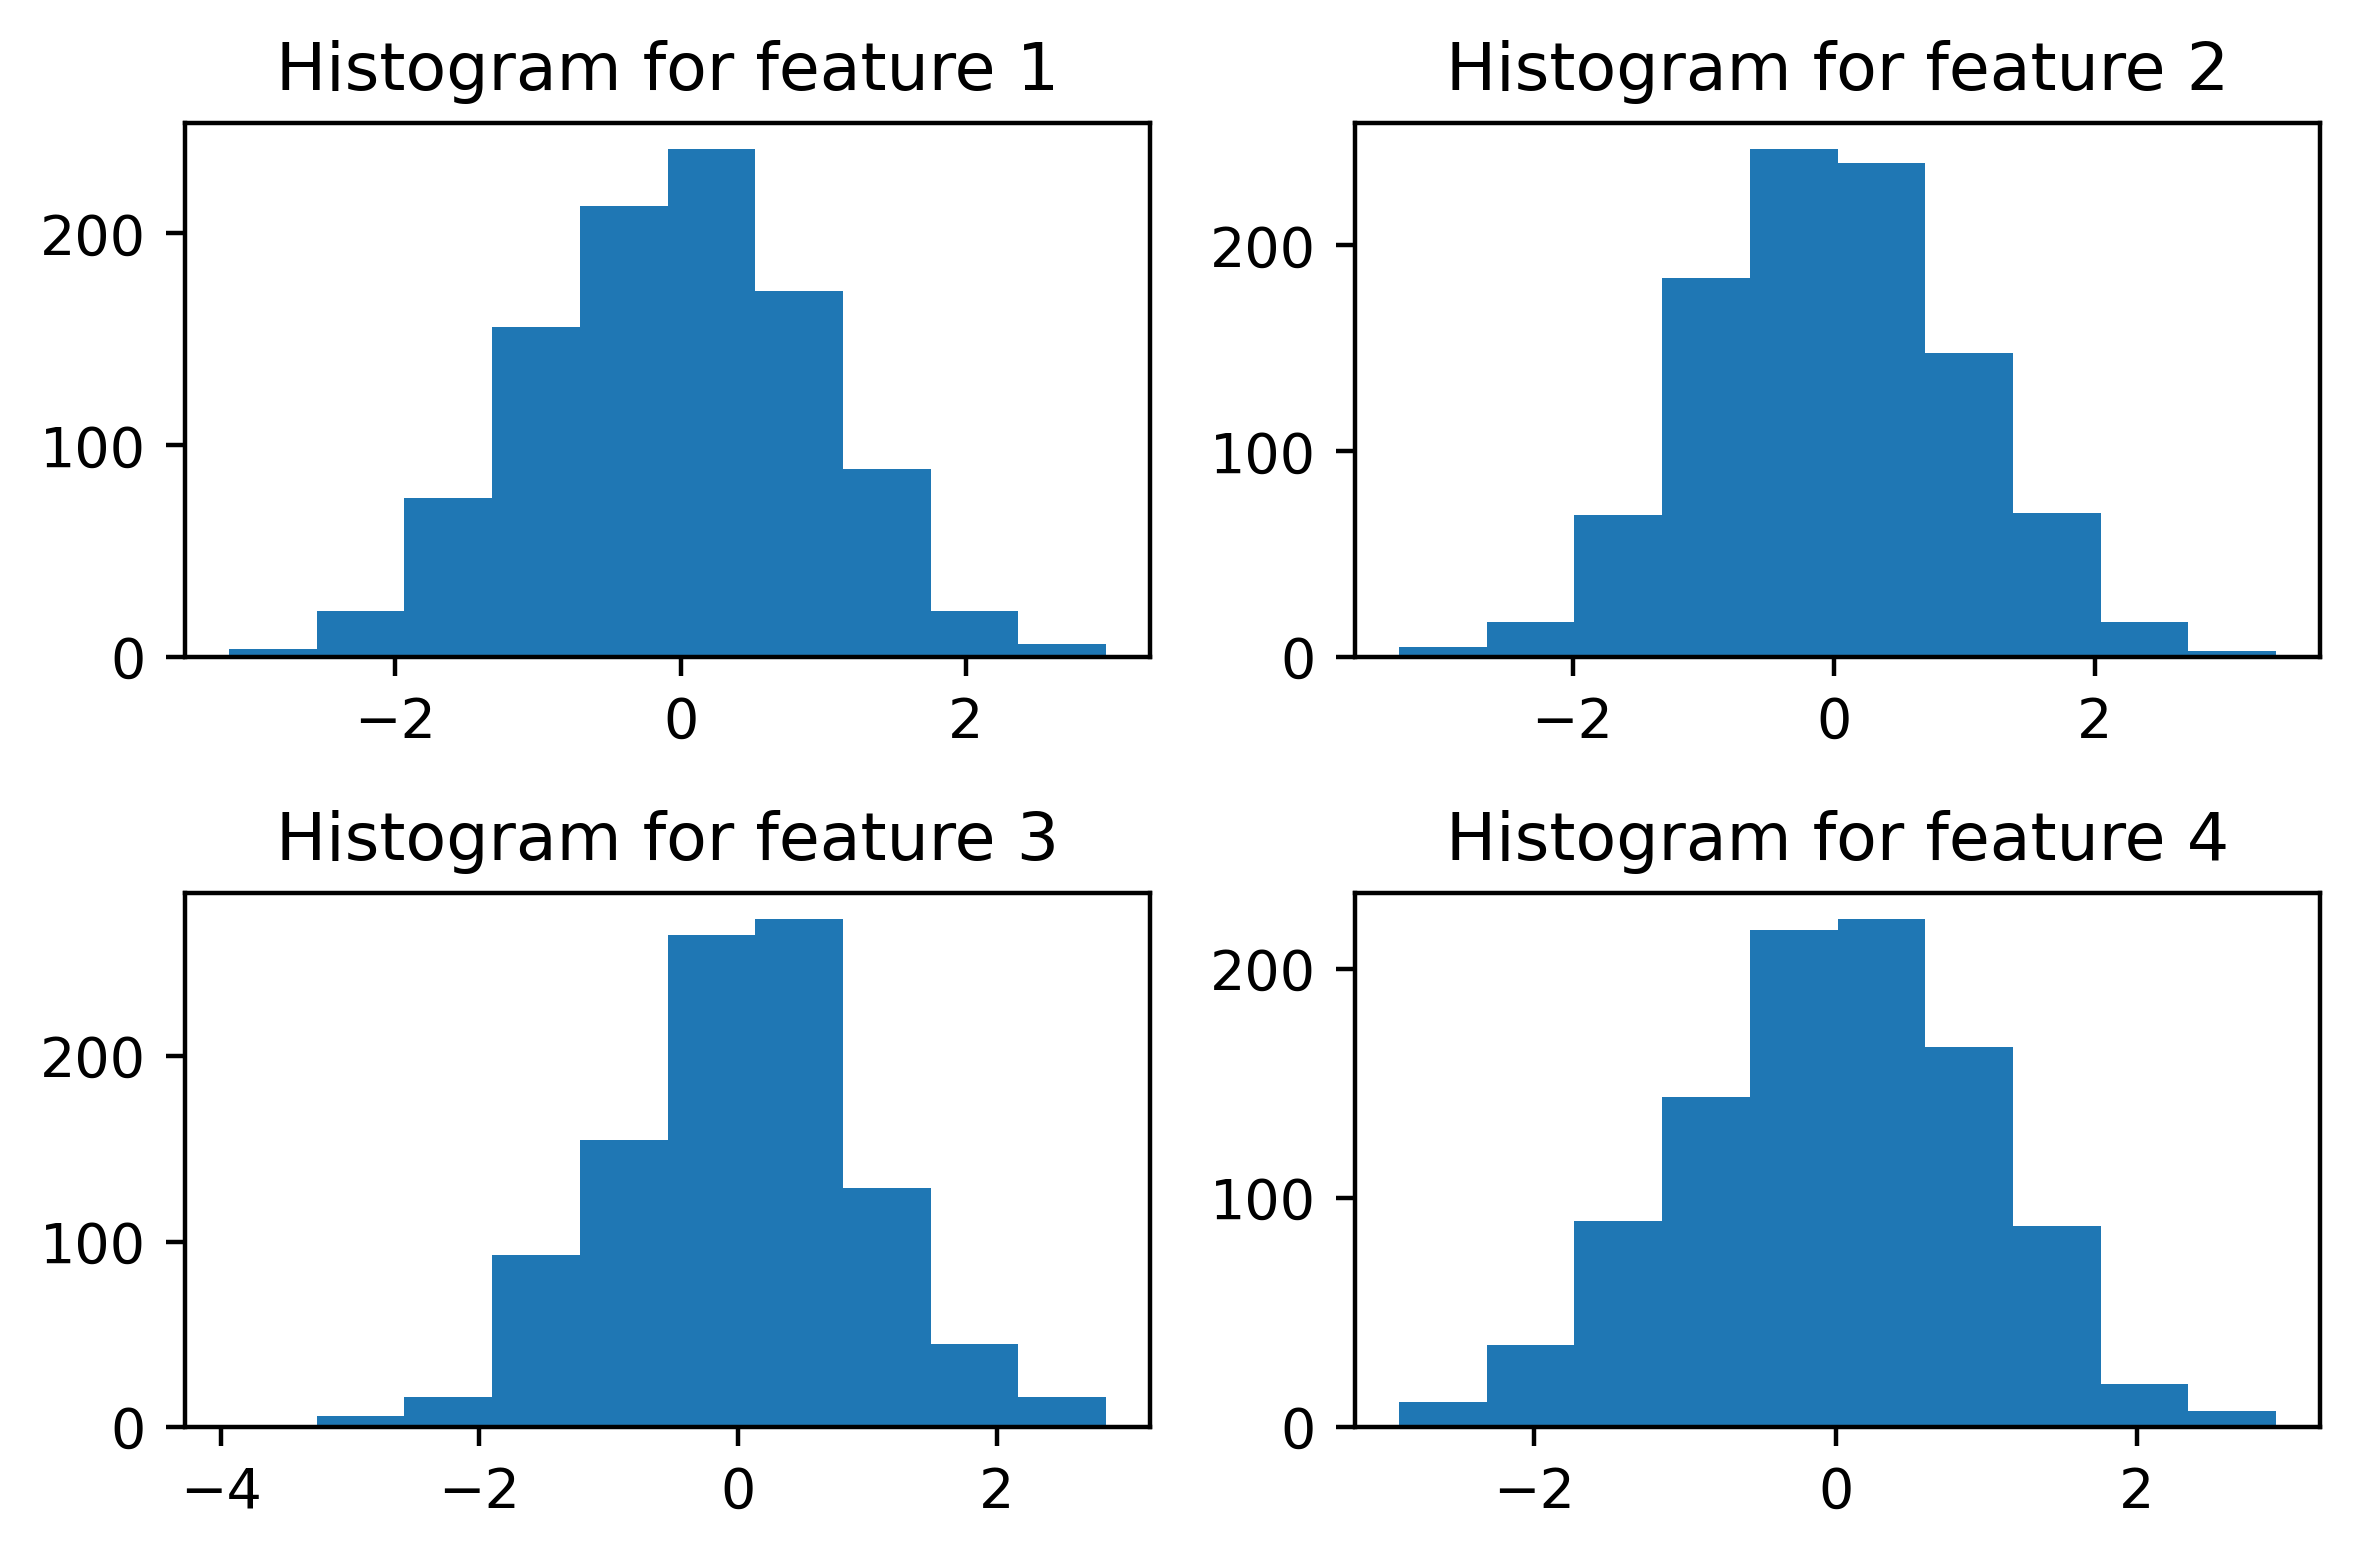

In [15]:
for plot_index in range(4):
     plt.subplot(2,2,plot_index+1)
     plt.hist(X_synthetic[:,plot_index])
     plt.title('Histogram for feature {}'.format(plot_index+1))
plt.tight_layout()

In [16]:
# Split the data
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(
    X_synthetic, y_synthetic,
    test_size=0.2, random_state=24
)

In [17]:
lr_syn = LogisticRegression(solver='liblinear', penalty='l1', C=1000, random_state=1)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
#predicted probabalities for training dataset
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train,y_syn_train_predict_proba[:,1])

0.9419937500000001

In [20]:
#predicted probabalities for testing dataset
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test,y_syn_test_predict_proba[:,1])

0.8074807480748075

###### From these results, it's apparent that the logistic regression model has overfit the data

### Cross Validation: Choosing the Regularization Parameter and Other Hyperparameters


In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

In [22]:
n_folds = 4
k_folds = KFold(n_splits = n_folds,shuffle = False,random_state=1)

In [23]:
def plot_kfolds(k_folds_iterator):
    fold_counter = 0
    for train_index, test_index in k_folds_iterator.split(X_syn_train, y_syn_train):
 
        #Axis to hold the plot of this fold
        ax = plt.subplot(n_folds,1,fold_counter+1)
 
        #Background rectangle representing all samples
        n_train_samples = len(y_syn_train)
        rect = mpl.patches.Rectangle(xy=(0,0), width=n_train_samples, height=1)
        ax.add_patch(rect)
 
        #Plot each testing sample from this fold as a vertical line
        for this_text_ix in test_index:
            ax.plot([this_text_ix, this_text_ix], [0, 1], color='orange',
                    linewidth=0.75)
 
        #Plot formatting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, n_train_samples)
        ax.set_ylim(0,1)
 
        #Subplot titles
        if fold_counter == 0:
            ax.text(0.26, 1.2, 'Training data,',
                    transform=ax.transAxes, backgroundcolor = 'blue')
            ax.text(0.45, 1.2, 'testing data:',
                    transform=ax.transAxes, backgroundcolor = 'orange')
            ax.text(0.62, 1.2, 'fold {}'.format(fold_counter+1), transform=ax.transAxes)
        else:
            ax.text(0.45, 1.2, 'Fold {}'.format(fold_counter+1), transform=ax.transAxes)
 
        fold_counter += 1
 
    plt.tight_layout()

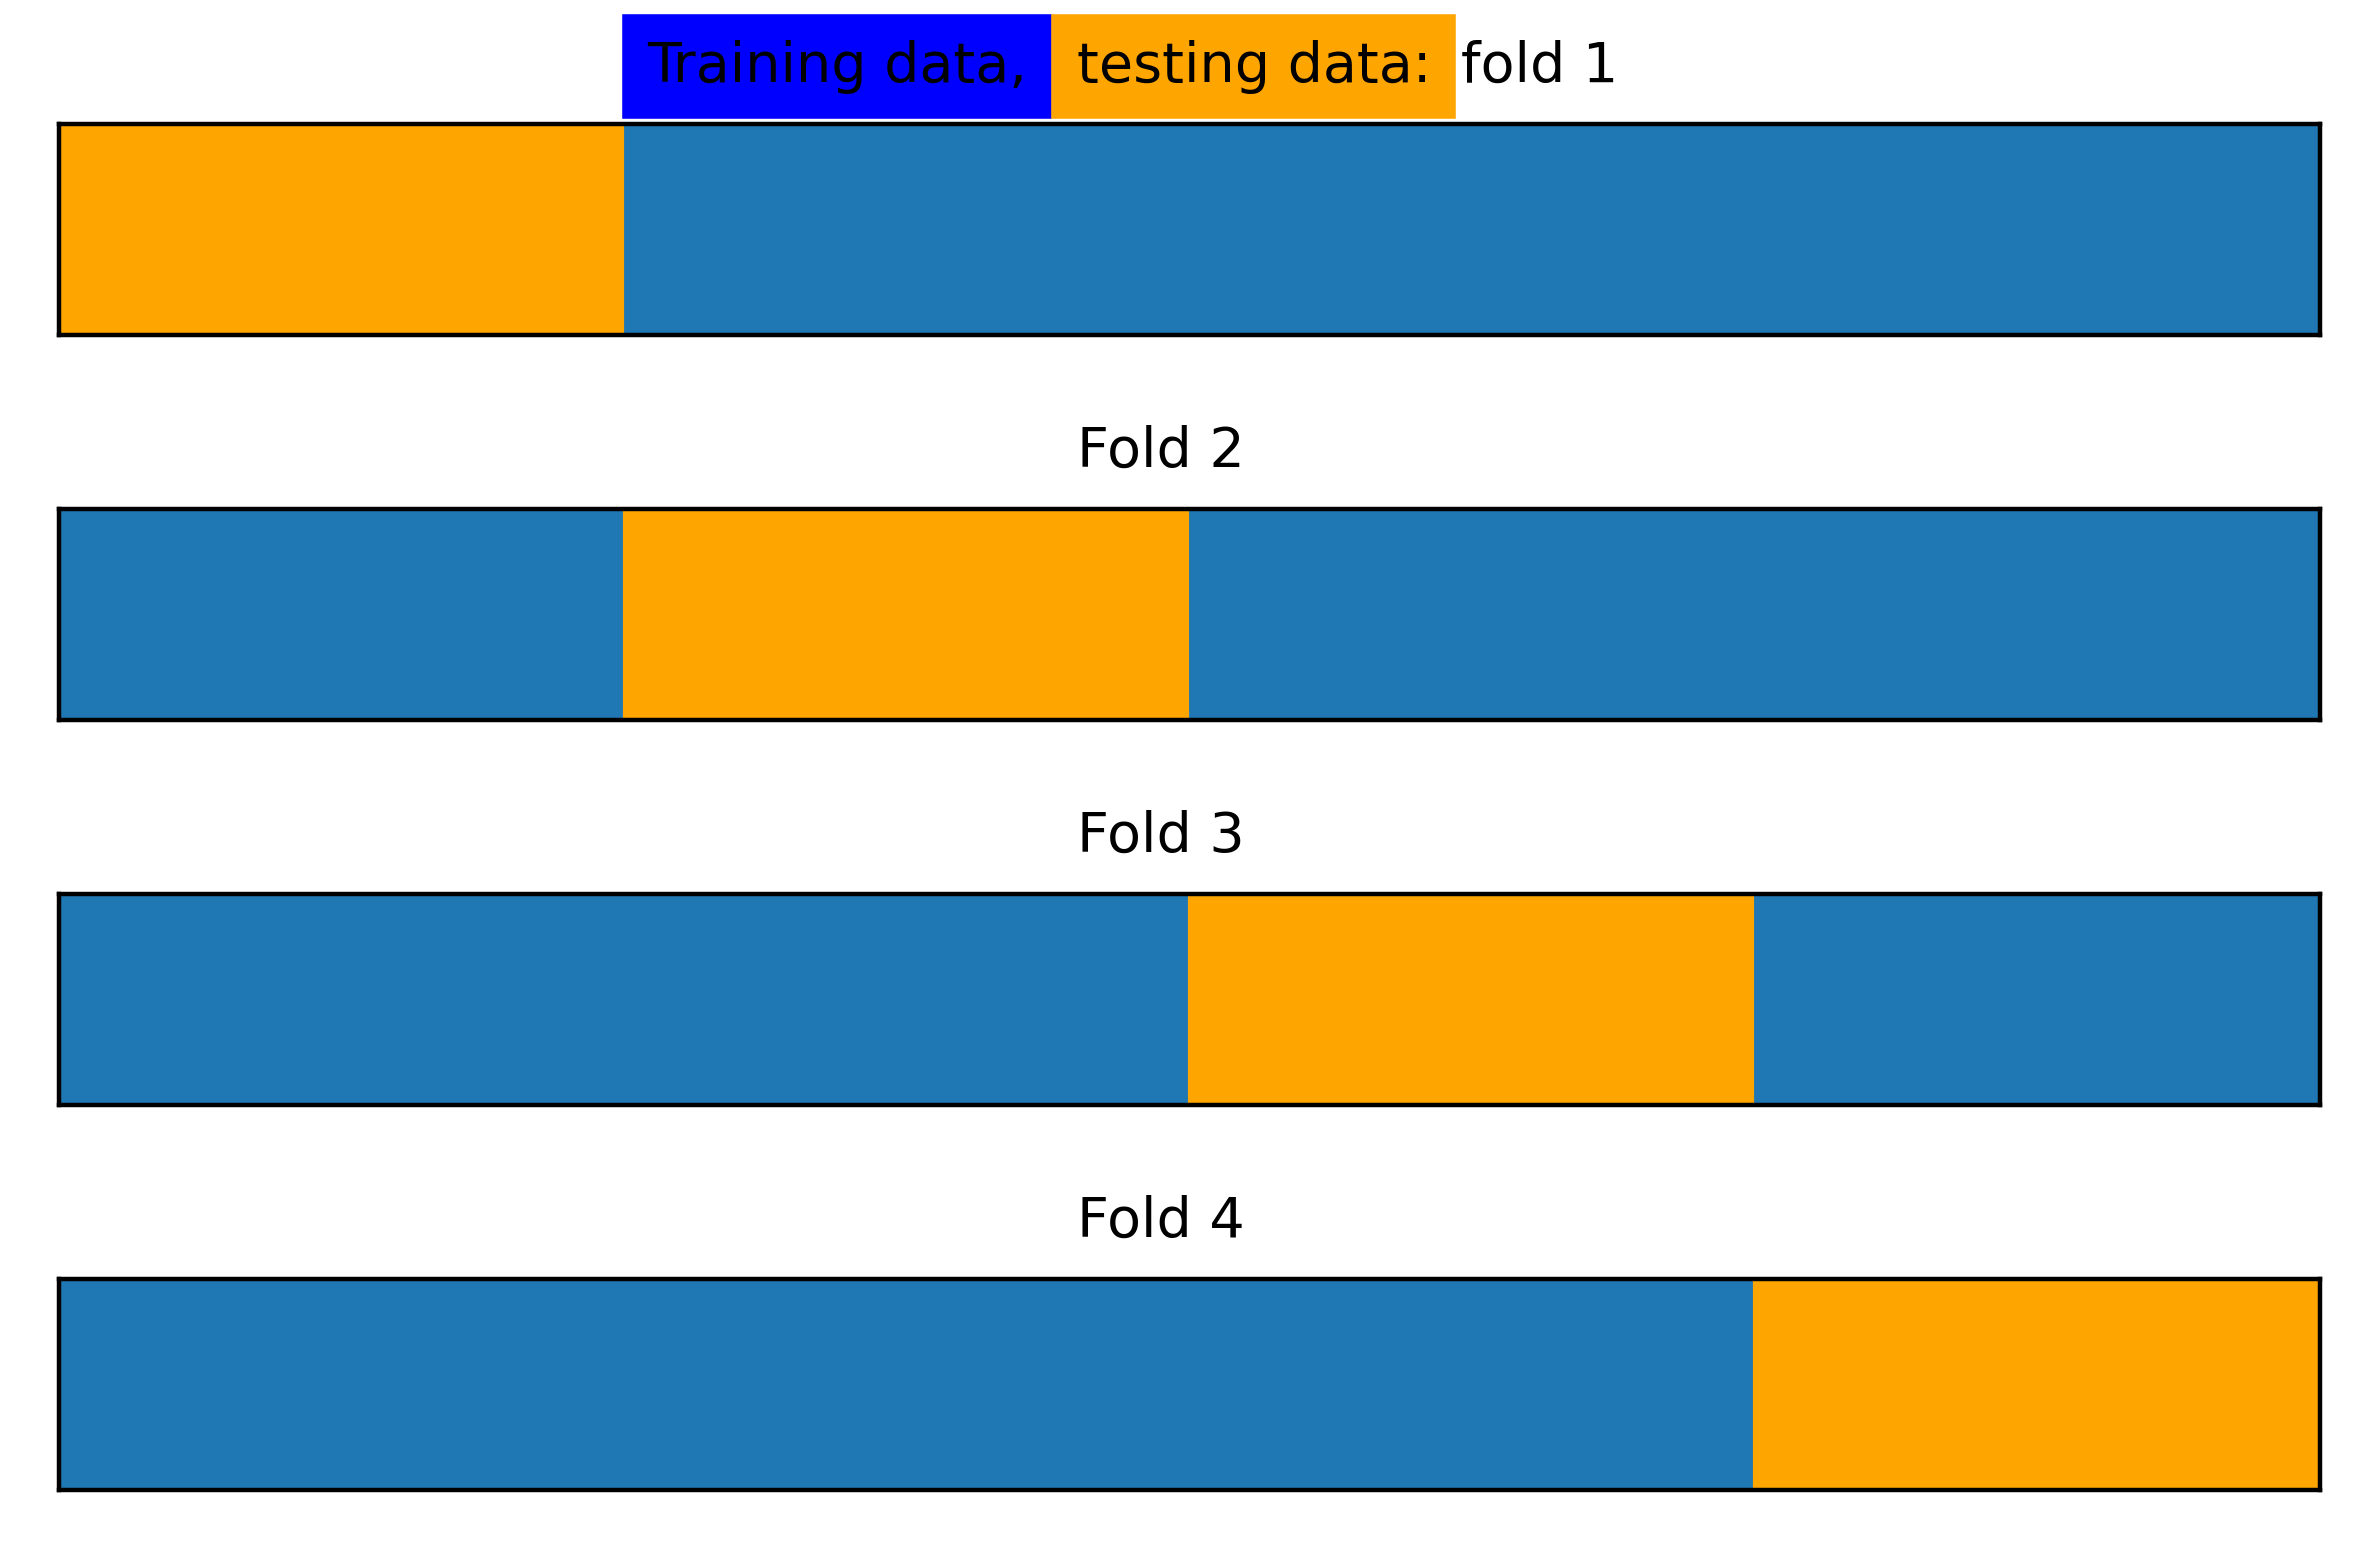

In [24]:
plot_kfolds(k_folds)

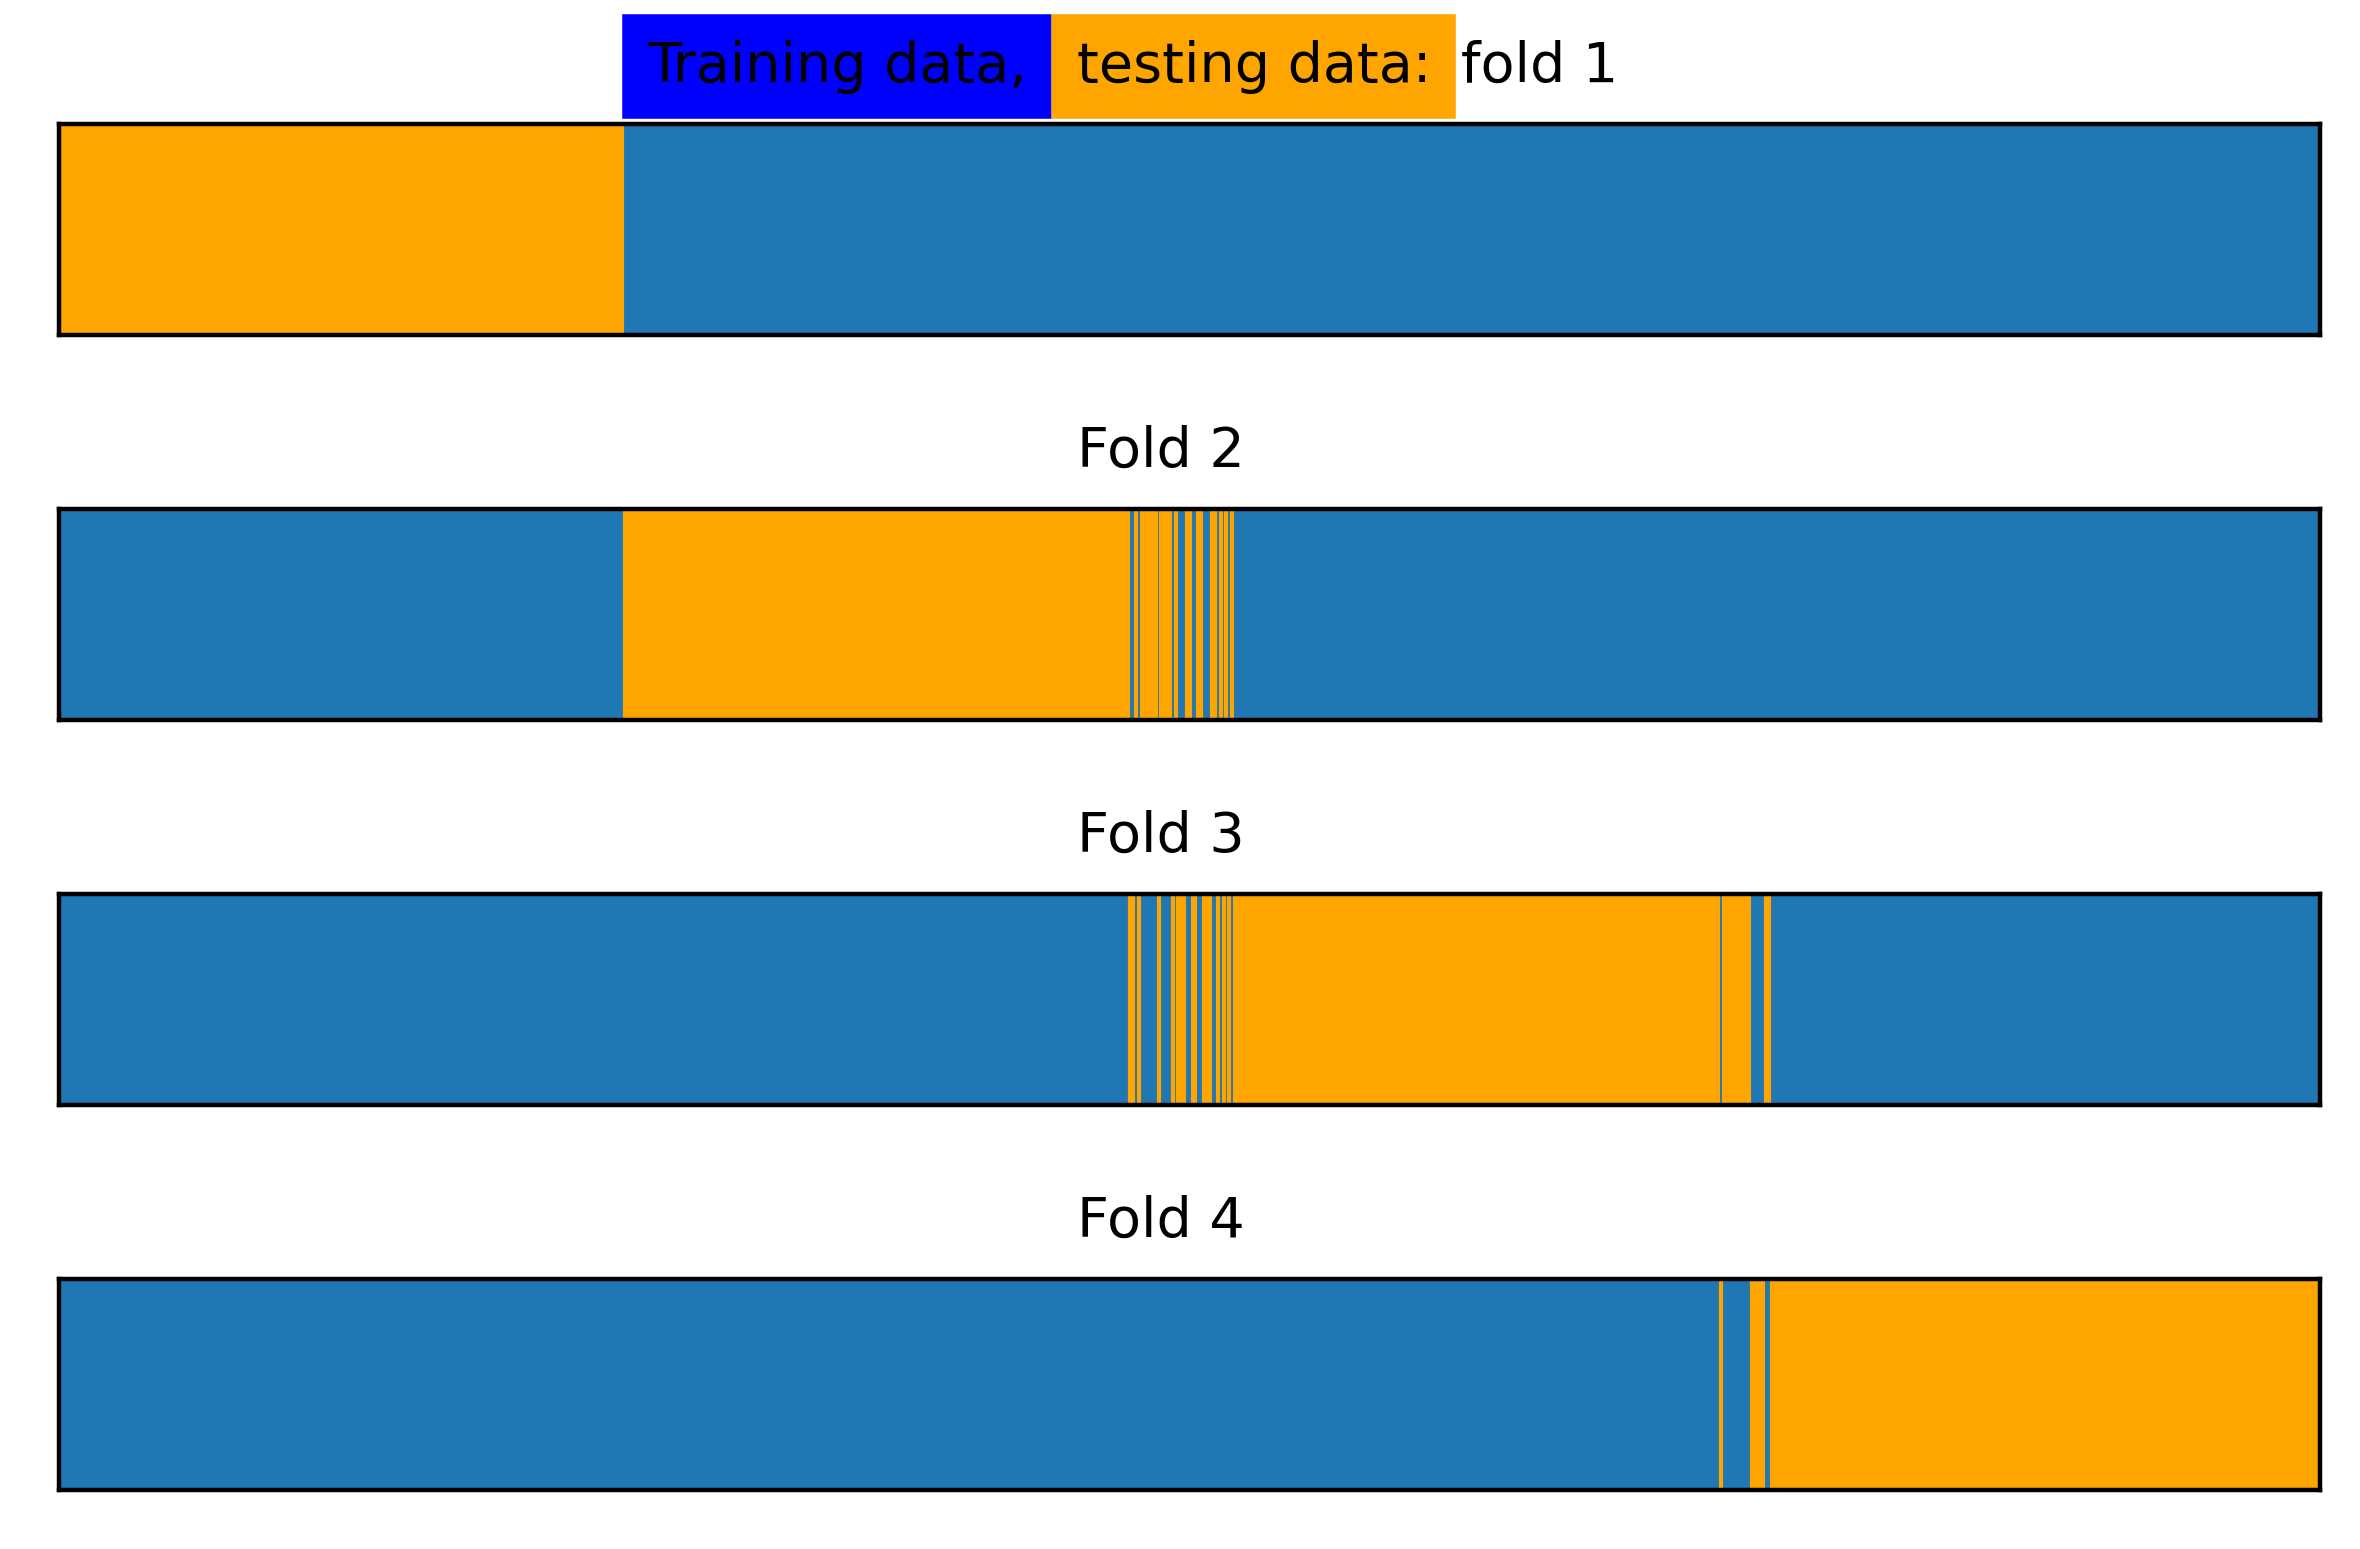

In [25]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=False, random_state=1)
plot_kfolds(k_folds)

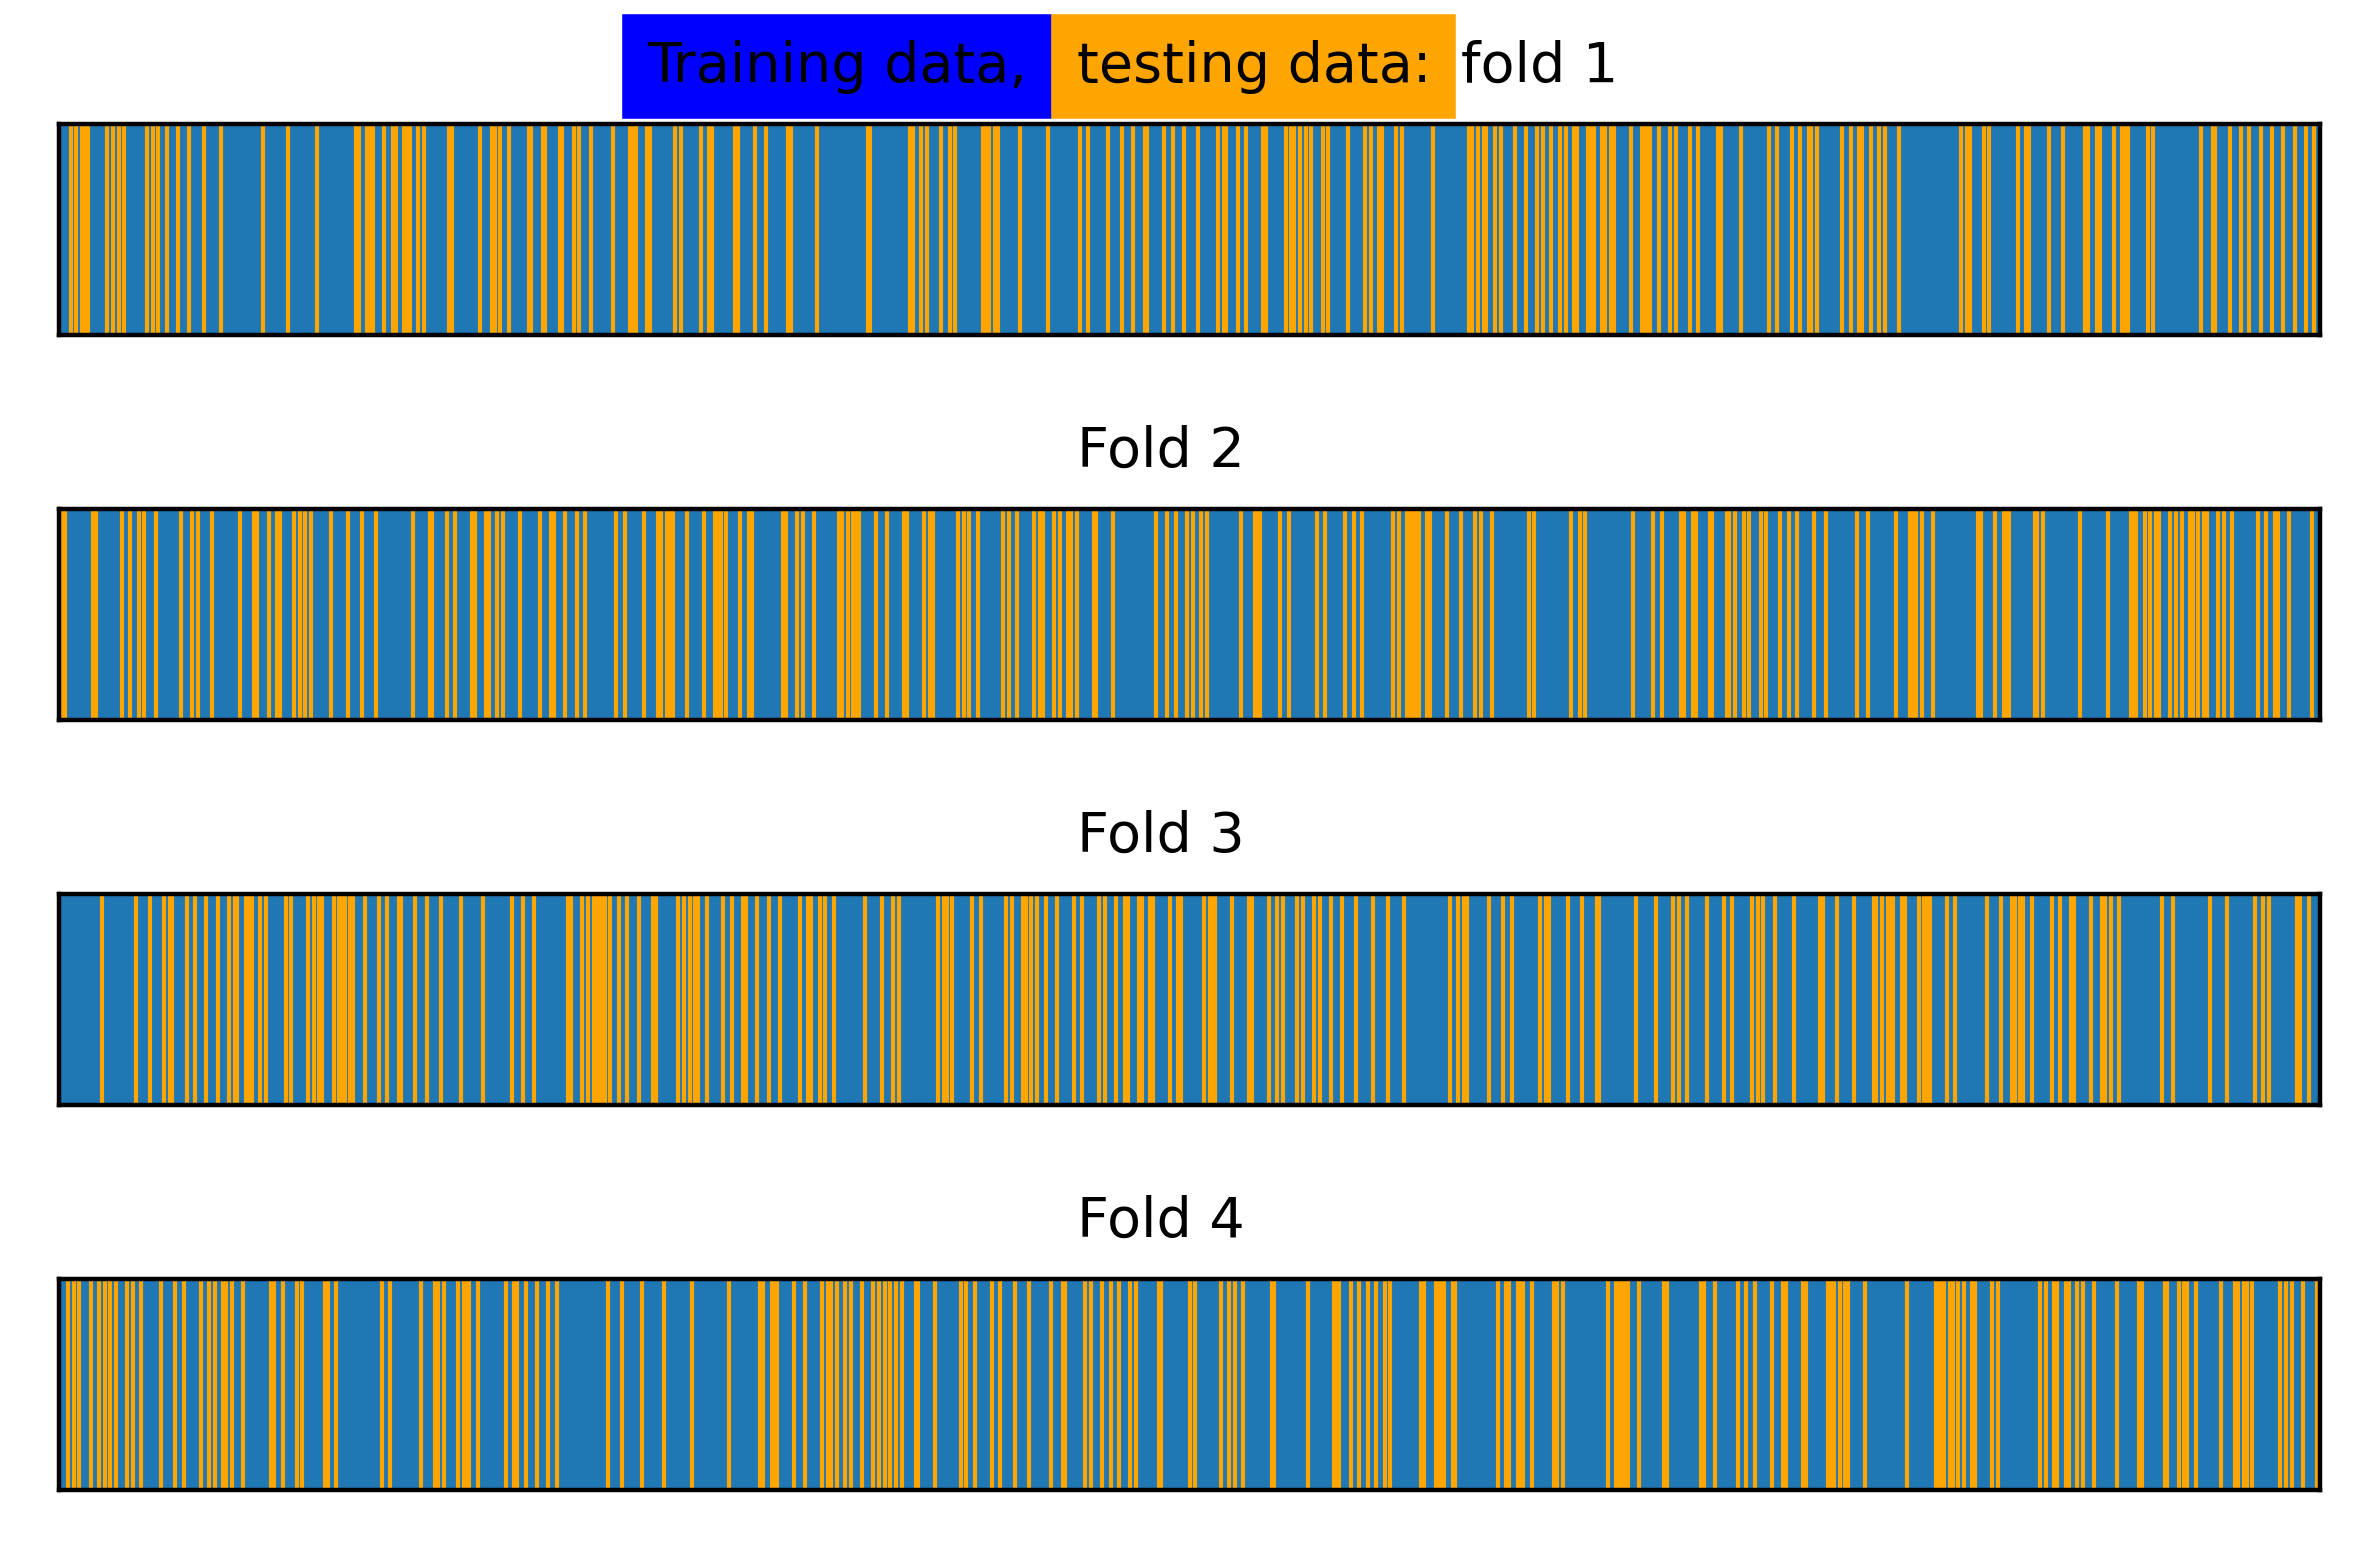

In [26]:
k_folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)
plot_kfolds(k_folds)

### Reducing Overfitting on the Synthetic Data Classification Problem


In [27]:
C_val_exponents = np.linspace(3,-3,13)
C_val_exponents

array([ 3. ,  2.5,  2. ,  1.5,  1. ,  0.5,  0. , -0.5, -1. , -1.5, -2. ,
       -2.5, -3. ])

In [28]:
# Let's do 10 power of exponents
C_vals = np.float(10)**C_val_exponents
C_vals

array([1.00000000e+03, 3.16227766e+02, 1.00000000e+02, 3.16227766e+01,
       1.00000000e+01, 3.16227766e+00, 1.00000000e+00, 3.16227766e-01,
       1.00000000e-01, 3.16227766e-02, 1.00000000e-02, 3.16227766e-03,
       1.00000000e-03])

In [29]:
from sklearn.metrics import roc_curve

In [30]:
# Now we have several C values [C_vals] and kfolds(4)
def cross_val_C_search(k_folds, C_vals, model, X, Y):
    n_folds = k_folds.n_splits
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    # store all these values let's create a list 
    cv_test_roc = [[]]*len(C_vals)
    
    for c_val_counter in range(len(C_vals)):
        #Set the C value for the model object
        model.C = C_vals[c_val_counter]
        #Count folds for each value of C
        fold_counter = 0
        
        #Get training and testing indices for each fold
        for train_index, test_index in k_folds.split(X, Y):
            #Subset the features and response, for training and testing data for this fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            
            #Fit the model on the training data
            model.fit(X_cv_train, y_cv_train)
            
            #Get the training ROC AUC
            y_cv_train_predict_proba = model.predict_proba(X_cv_train)
            cv_train_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_train, y_cv_train_predict_proba[:,1])
            
            #Get the testing ROC AUC
            y_cv_test_predict_proba = model.predict_proba(X_cv_test)
            cv_test_roc_auc[fold_counter, c_val_counter] = \
            roc_auc_score(y_cv_test, y_cv_test_predict_proba[:,1])
            
            #Testing ROC curves for each fold
            this_fold_roc = roc_curve(y_cv_test, y_cv_test_predict_proba[:,1])
            cv_test_roc[c_val_counter].append(this_fold_roc)
            
            #Increment the fold counter
            fold_counter += 1
        
        #Indicate progress
        print('Done with C = {}'.format(lr_syn.C))
        
    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [31]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = \
cross_val_C_search(k_folds, C_vals, lr_--syn, X_syn_train, y_syn_train)

Done with C = 1000.0
Done with C = 316.22776601683796
Done with C = 100.0
Done with C = 31.622776601683793
Done with C = 10.0
Done with C = 3.1622776601683795
Done with C = 1.0
Done with C = 0.31622776601683794
Done with C = 0.1
Done with C = 0.03162277660168379
Done with C = 0.01
Done with C = 0.0031622776601683794
Done with C = 0.001


Text(0.5, 1.0, 'Cross validation scores for each fold')

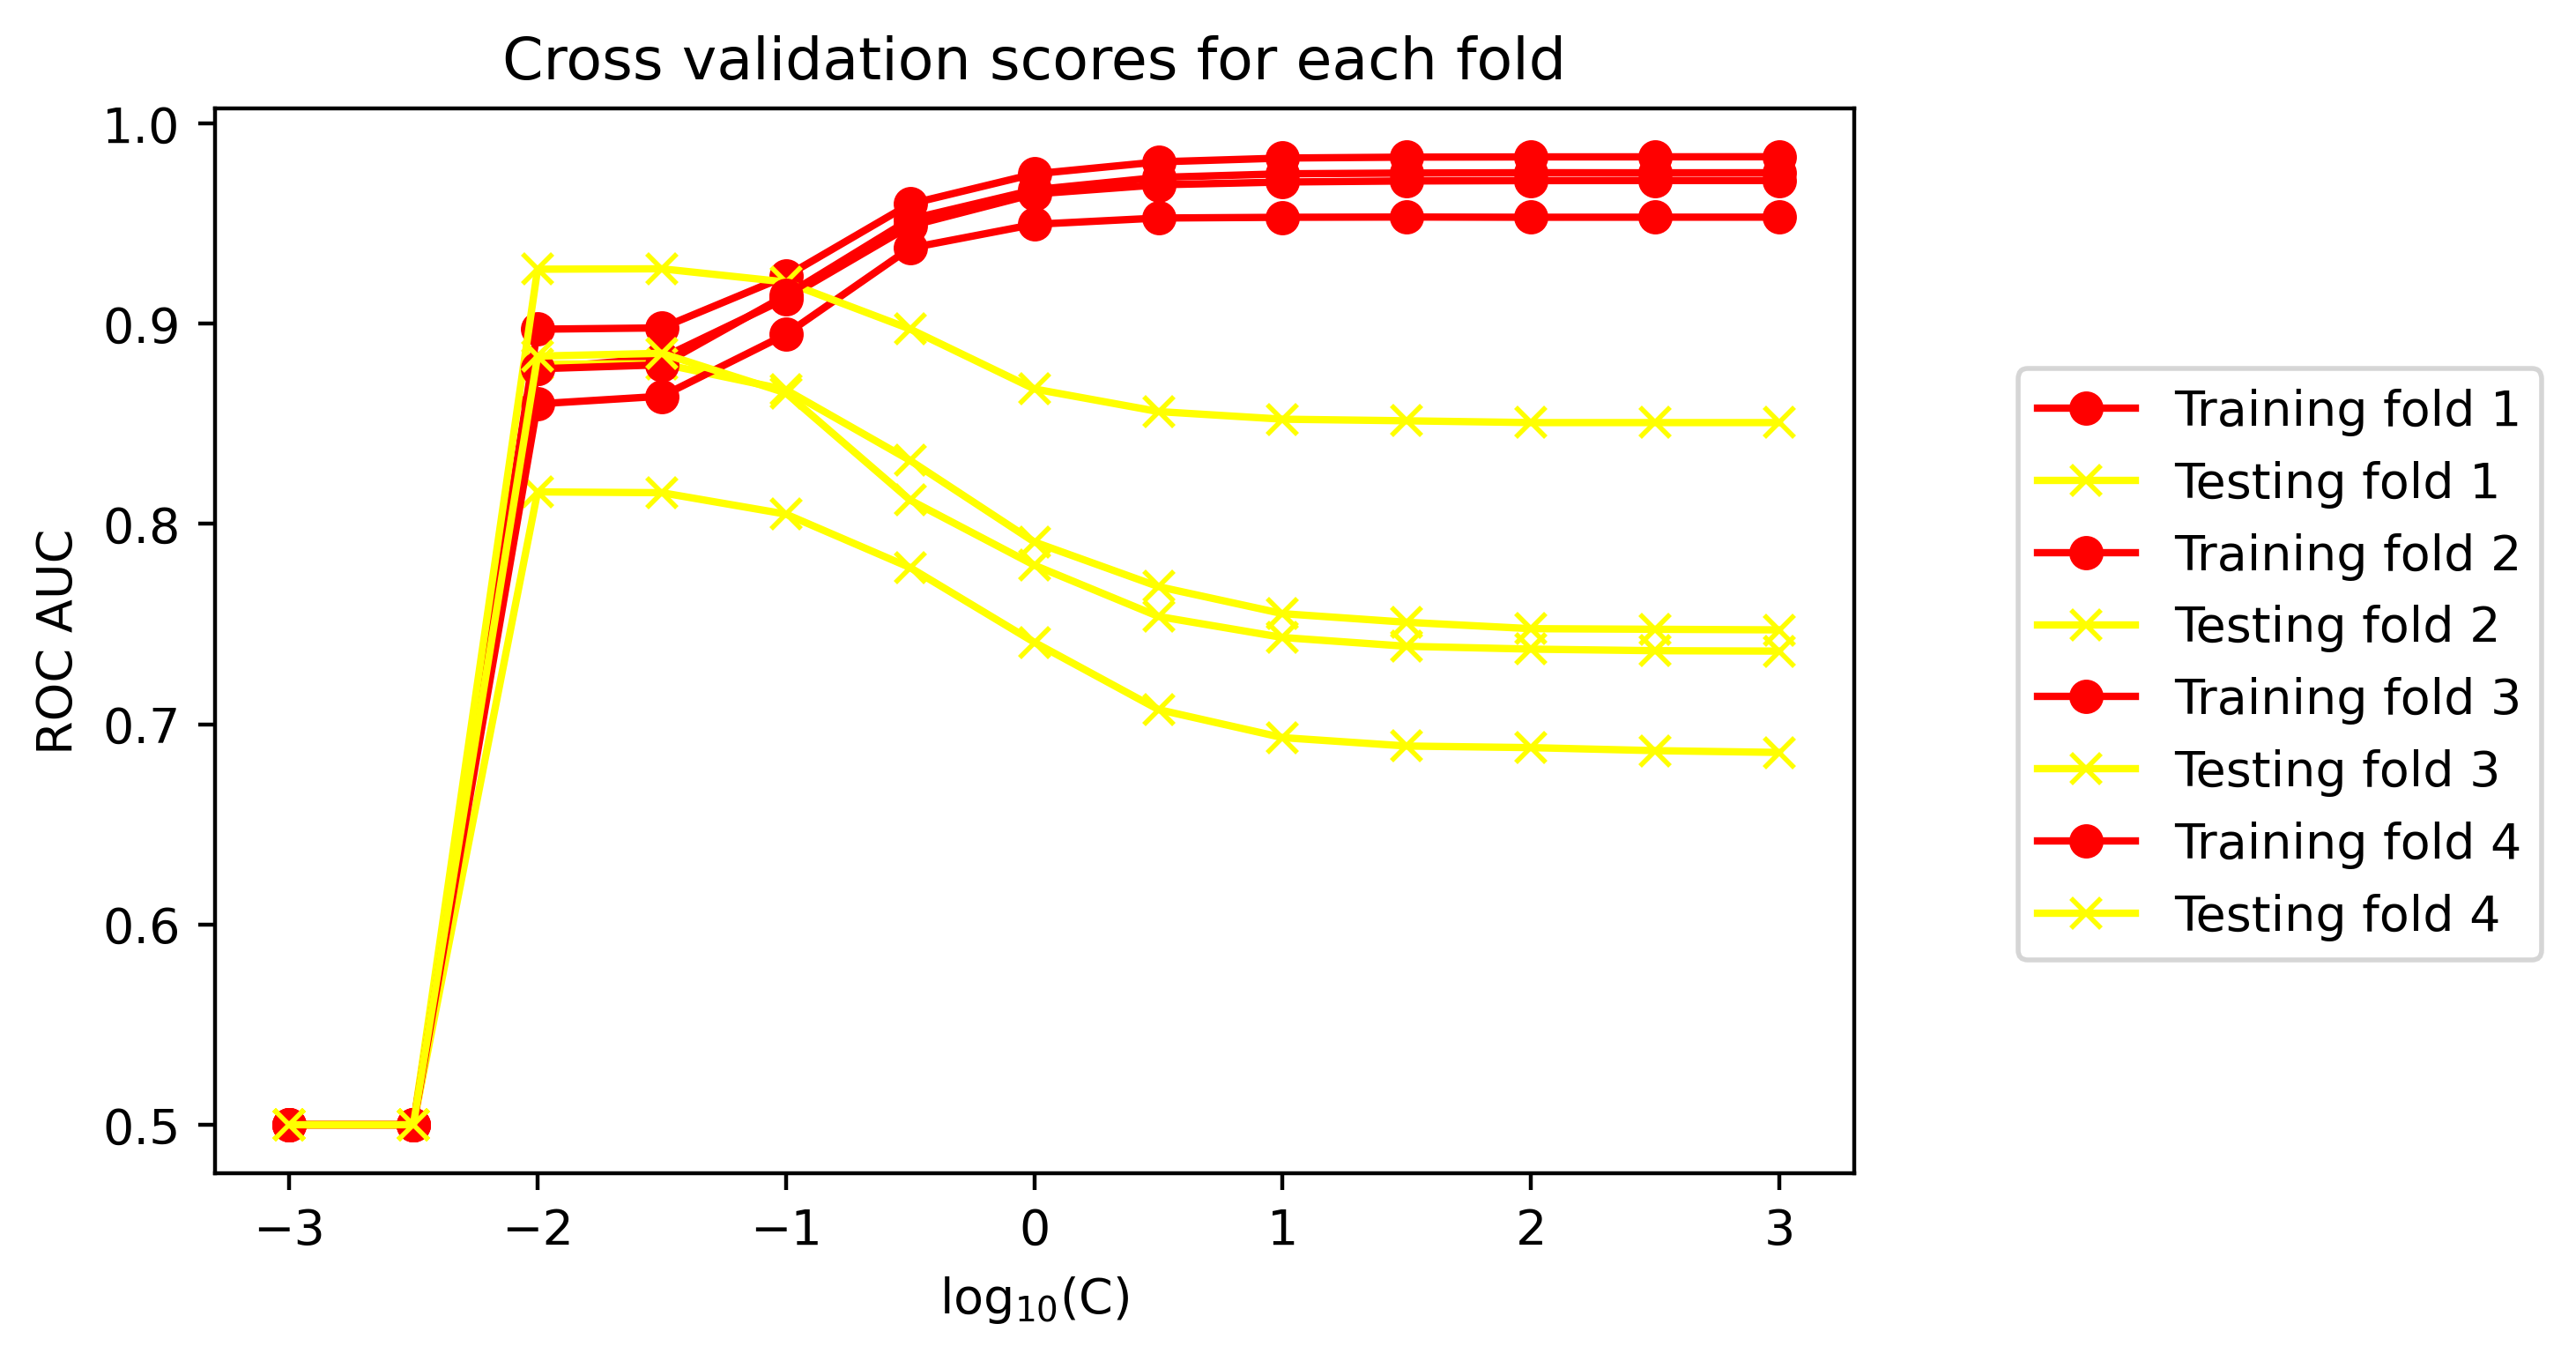

In [32]:
# Let's visualize the this for train and test sets on y-axis and C values on X-axis
for this_fold in range(n_folds):
    plt.plot(C_val_exponents, cv_train_roc_auc[this_fold], '-o',
             color='red', label='Training fold {}'.format(this_fold+1))
    plt.plot(C_val_exponents, cv_test_roc_auc[this_fold], '-x',
             color='yellow', label='Testing fold {}'.format(this_fold+1))
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend(loc = [1.1, 0.2])
plt.title('Cross validation scores for each fold')

Text(0.5, 1.0, 'Cross validation scores averaged over all folds')

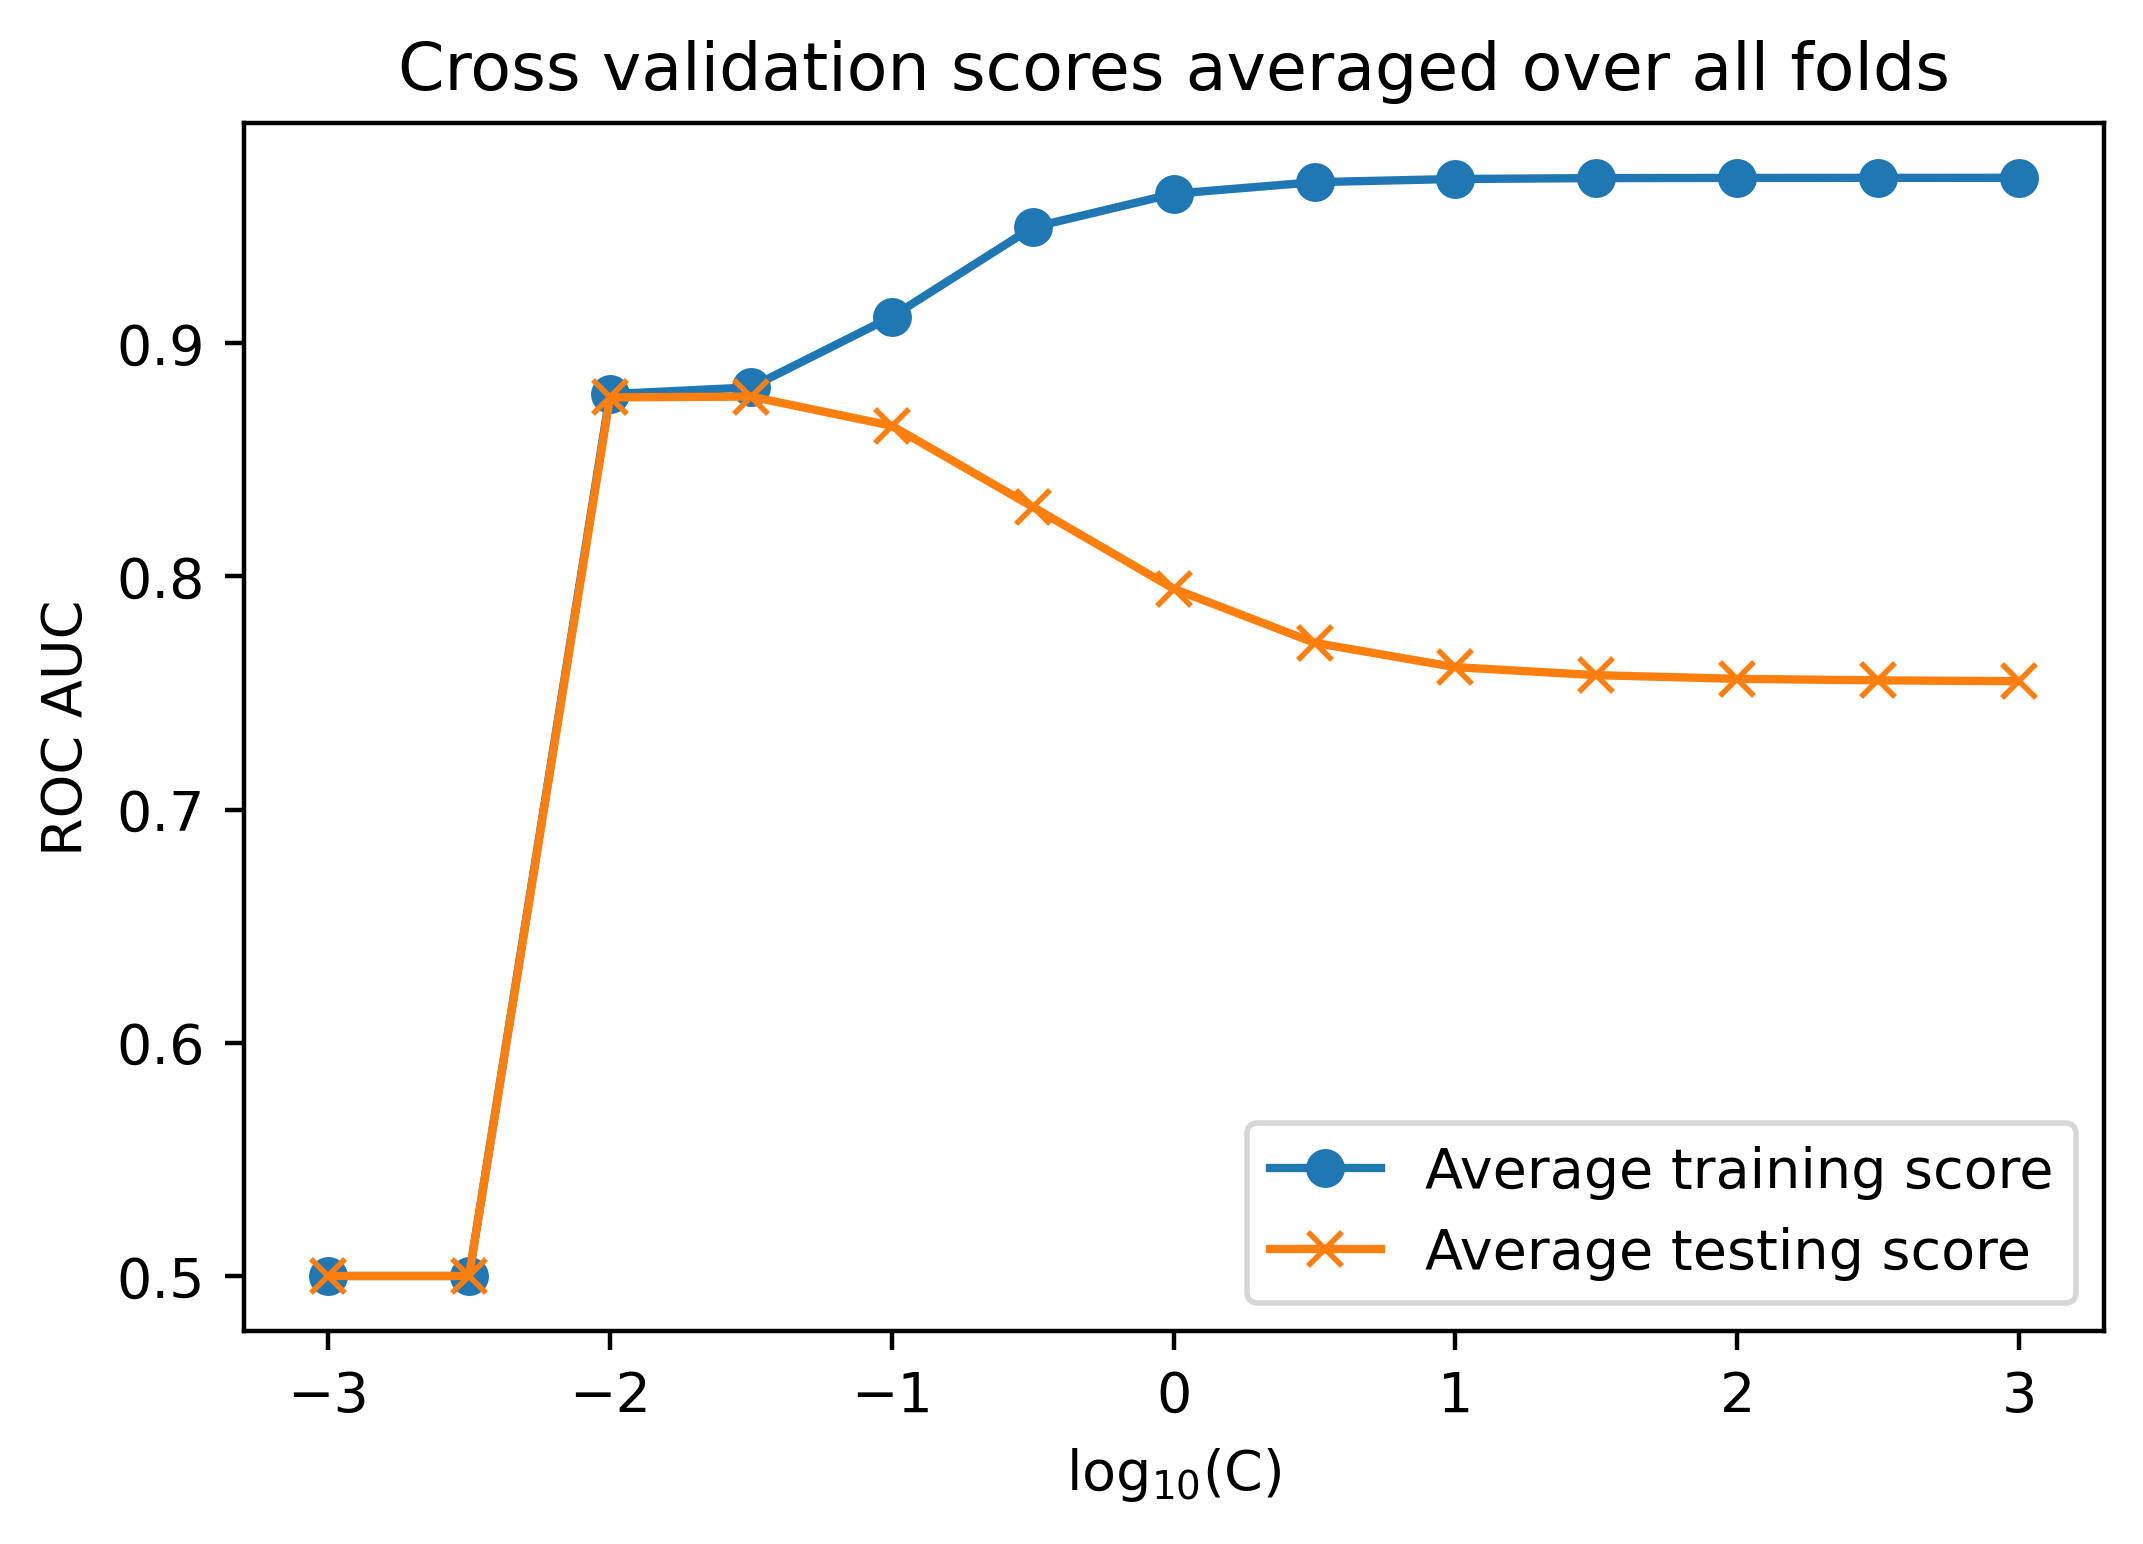

In [33]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o',
        label='Average training score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x',
        label='Average testing score')
plt.ylabel('ROC AUC')
plt.xlabel('log$_{10}$(C)')
plt.legend()
plt.title('Cross validation scores averaged over all folds')

In [34]:
np.mean(cv_test_roc_auc,0)

array([0.755025, 0.755375, 0.756025, 0.7576  , 0.761025, 0.771475,
       0.794675, 0.829775, 0.864525, 0.87705 , 0.8767  , 0.5     ,
       0.5     ])

In [35]:
np.mean(cv_train_roc_auc,0)

array([0.97085   , 0.97081944, 0.97079722, 0.97071389, 0.97034167,
       0.96897222, 0.96400556, 0.94960556, 0.91128056, 0.88099722,
       0.87809167, 0.5       , 0.5       ])

In [37]:
# according the above plot 10-1.5 and 10-2 are best C values
best_C_val_bool = C_val_exponents == -1.5                    # converting float into int
best_C_val_bool.astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [38]:
# index of c value
best_C_val_ix = np.nonzero(best_C_val_bool.astype(int))
best_C_val_ix[0][0]

9

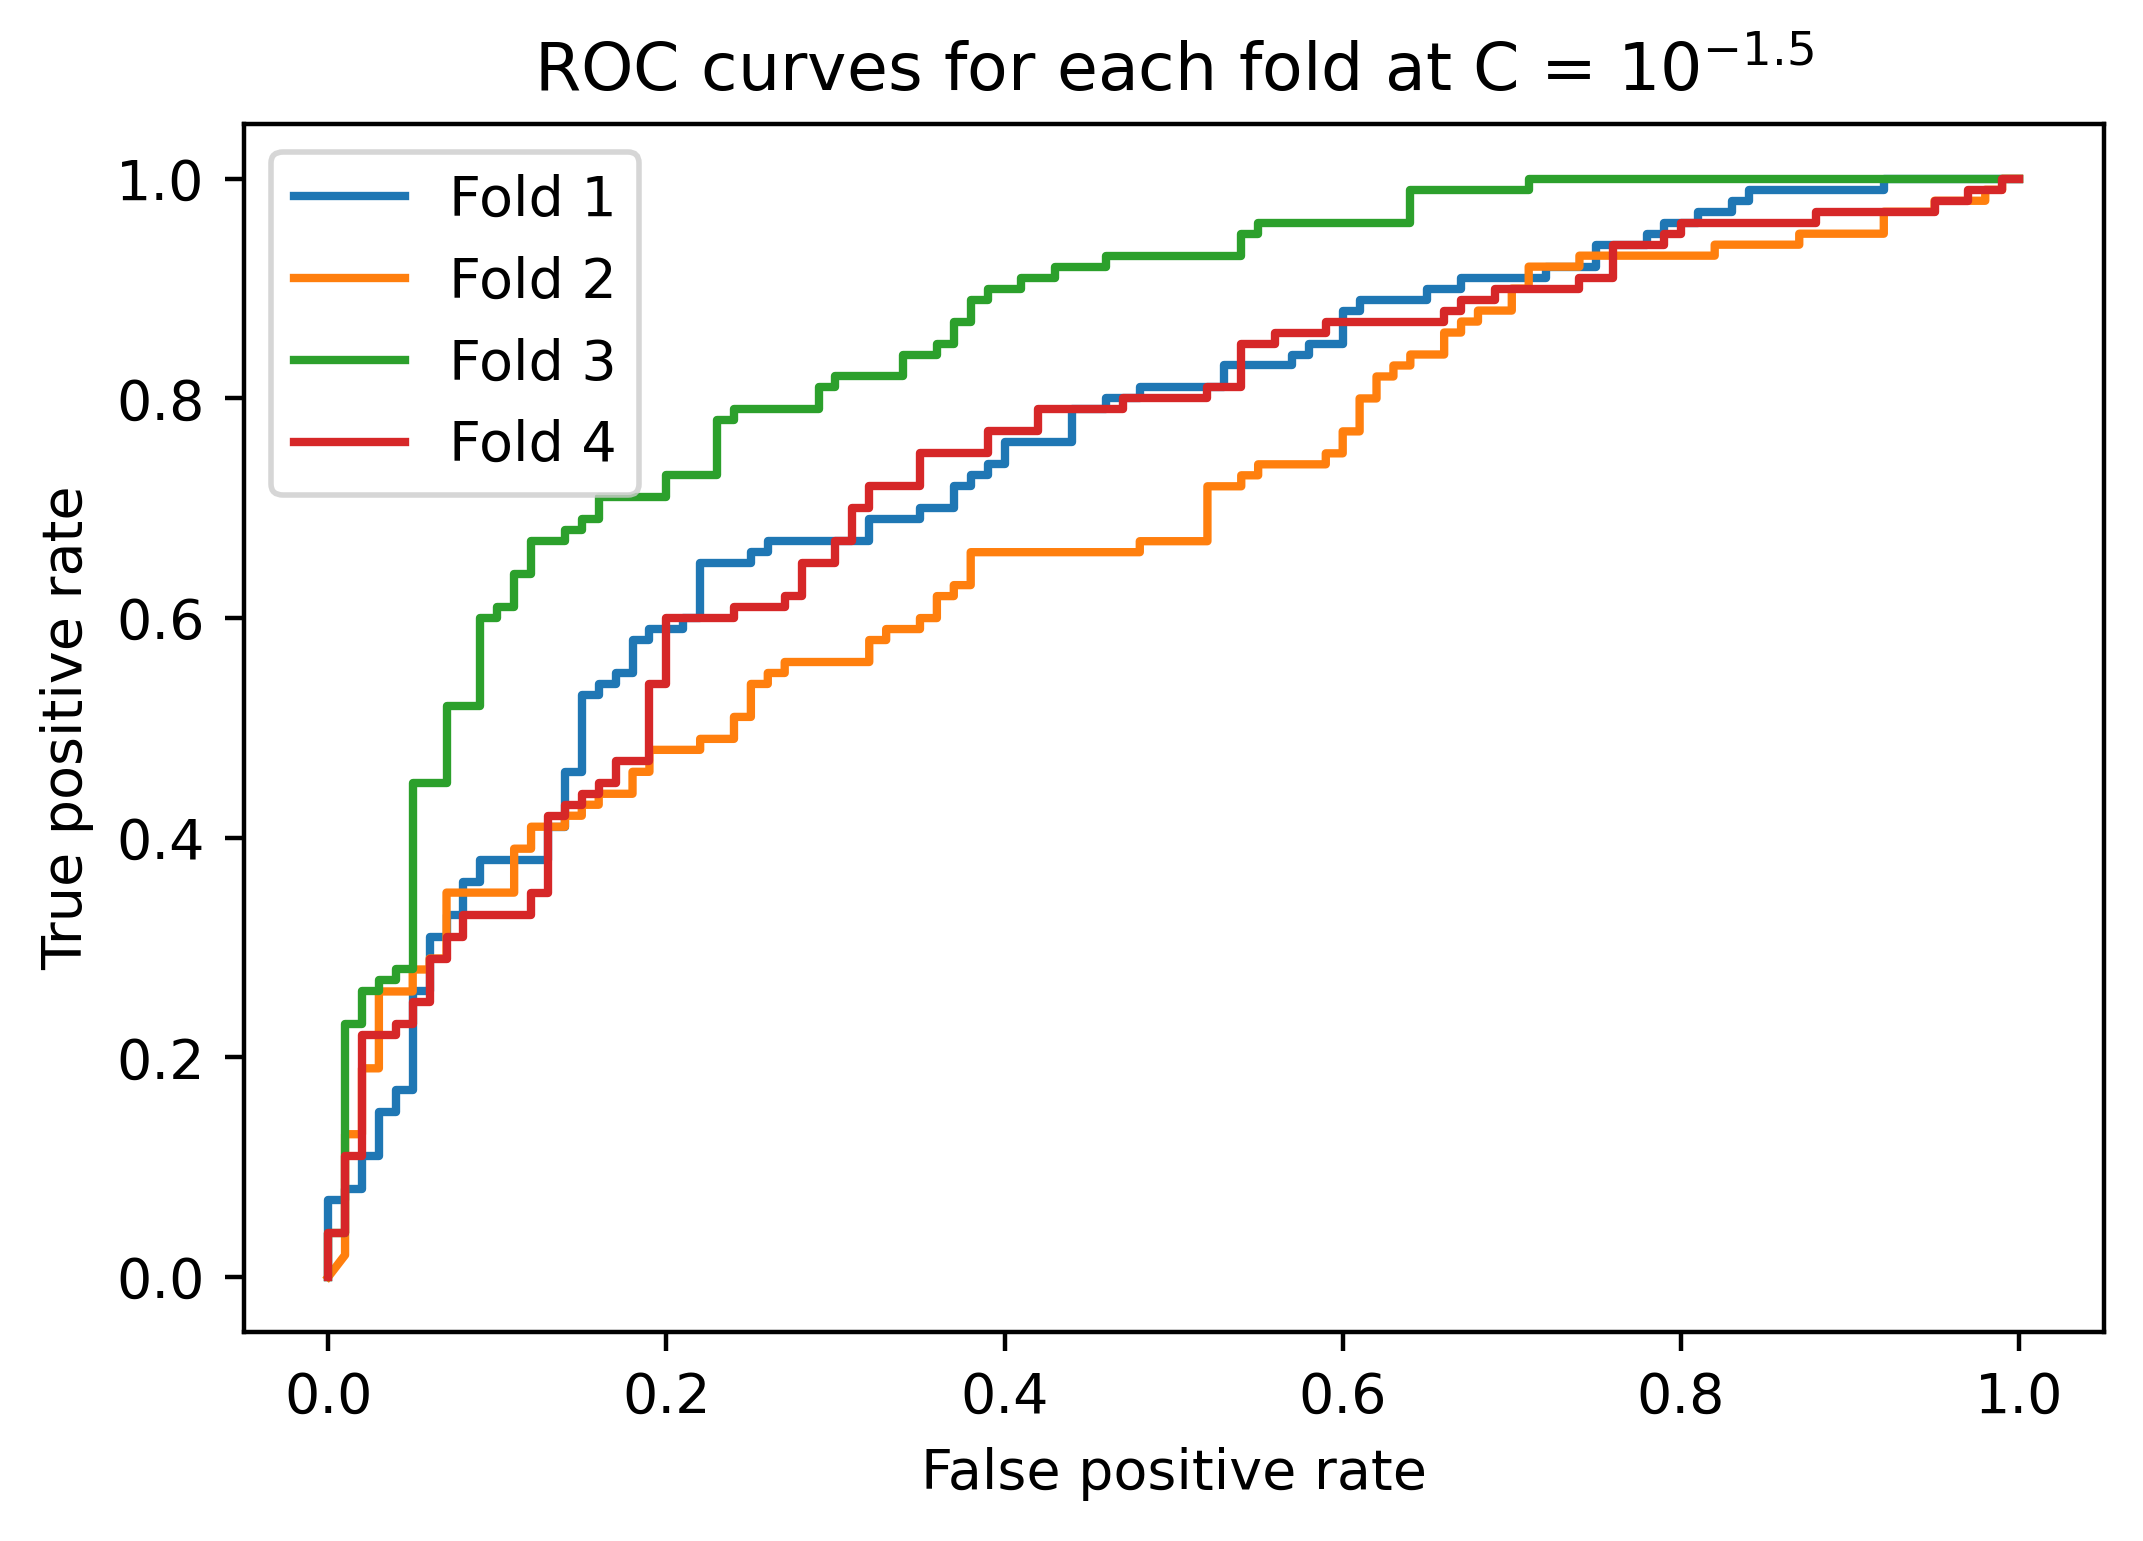

In [39]:
for this_fold in range(n_folds):
    fpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][0]
    tpr = cv_test_roc[best_C_val_ix[0][0]][this_fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(this_fold+1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for each fold at C = $10^{-1.5}$')
plt.legend()

In [40]:
# Let's use C as -1.5
lr_syn.C = 10**(-1.5)
lr_syn.fit(X_syn_train, y_syn_train)

LogisticRegression(C=0.03162277660168379, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=1, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# Let's obtain pred probabilities for train set
y_syn_train_predict_proba = lr_syn.predict_proba(X_syn_train)
roc_auc_score(y_syn_train, y_syn_train_predict_proba[:,1])

0.8802812499999999

In [42]:
# Let's obtain pred probabilities for test set
y_syn_test_predict_proba = lr_syn.predict_proba(X_syn_test)
roc_auc_score(y_syn_test, y_syn_test_predict_proba[:,1])

0.8847884788478848

In [43]:
# Trained model coef which are not equal to zero
sum((lr_syn.coef_ != 0)[0])

2

In [44]:
# intercept
lr_syn.intercept_

array([0.])